# Project Part 2. Recommender system

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
import data

In [2]:
df_movies = pd.read_csv('movies.csv')
df_links = pd.read_csv('links.csv')[['movieId', 'tmdbId', 'imdbId']]
df_movies = df_movies.merge(df_links, how='left', on='movieId')

# One-hot encoding for genre
df_movies = pd.concat([df_movies, df_movies.genres.str.get_dummies('|')], axis=1)
df_movies = df_movies.drop(columns=['(no genres listed)', 'genres'])

sorted_unique_ids = sorted(df_movies['movieId'].unique())

# Step 2: Create a mapping of IDs to indices based on the sorted order
id_to_index_mapping = {id: idx for idx, id in enumerate(sorted_unique_ids)}

# Step 3: Replace values in column movieId with the corresponding indices
df_movies['movieId'] = df_movies['movieId'].map(id_to_index_mapping)

df_movies

,movieId,title,tmdbId,imdbId,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),862.0,114709,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Jumanji (1995),8844.0,113497,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Grumpier Old Men (1995),15602.0,113228,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3,Waiting to Exhale (1995),31357.0,114885,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,Father of the Bride Part II (1995),11862.0,113041,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,9737,Black Butler: Book of the Atlantic (2017),432131.0,5476944,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,9738,No Game No Life: Zero (2017),445030.0,5914996,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,9739,Flint (2017),479308.0,6397426,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,9740,Bungo Stray Dogs: Dead Apple (2018),483455.0,8391976,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Collect movie data using tmdbv3api

### Create TMDb Object

In [3]:
from tmdbv3api import TMDb
from tmdbv3api import Movie
tmdb=TMDb()
#set you unique API key that you get from TMDB after registartion in my case this is my API key
TMDb.api_key='eb694832e717f6712c1cbe5c7ec09f92'
#you can also export your api key as environment variable using this below export command
# export TMDb_API_KEY='6f15568d9aa3d15d0261a5454578c28b'
#it's optional it's for setting language of Data that we'll fetch from TMDB
tmdb.language = 'en'
#for debugging we have set it true 
tmdb.debug = True
movie=Movie()
#here I have fetched movie data using movie_id 
similar = movie.similar(343611)
#iterate through the data since it have multiple information
for s in similar:
    #print required data like in my case title of movie and it's overview, poster path
    print("Title of the movie: ", s.title)
    print("Overview of the movie:", s.overview)
    print("Poster of the Movie:", s.poster_path)

Title of the movie:  Freeway
Overview of the movie: A deeply-disturbed priest goes on a murderous night-time rampage across America's highways.
Poster of the Movie: /cxv8MRnpAhd4izS0yHHeQPgn6FR.jpg
Title of the movie:  King Lily of the Valley
Overview of the movie: Spring is in the air and Puck and Einar, as well as Christer Wijk are invited to a wedding in Skoga. The day before the wedding, the bride-to-be enters a flower-shop in order to inspect her bridal bouquet of lily of the valley, but suddenly vanishes without at trace. When she eventually turns up again, it is Christer who finds her. She lies dead outside her home with a bouquet of lily of the valley in her hand. Everybody close to the bride are suspects, not least her best friend, whom Christer has just begun flirting with. Everybody seems to have something to hide. Question is: are their secrets connected to the murder?
Poster of the Movie: /6LUaucJOSeCazvb9ZTvADLd2uhS.jpg
Title of the movie:  Friday the 13th Part VI: Jason 

### Extract movie details by id

In [4]:
import pickle

try:
    with open('movie_info.pickle', 'rb') as handle:
        movie_info = pickle.load(handle)
except:
    movie_info = []
    for tmdb_id in tqdm(df_movies.tmdbId):
        try:
            movie_detail = movie.details(tmdb_id)
            movie_info.append([movie_detail['vote_average'], 
                               movie_detail['overview'], 
                               movie_detail['popularity']])
        except:
            movie_info.append([])
    with open('movie_info.pickle', 'wb') as handle:
        pickle.dump(movie_info, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Process movie information

In [5]:
from sentence_transformers import SentenceTransformer
deep_embedder = SentenceTransformer('all-MiniLM-L6-v2')


In [28]:
movie_scores = []
movie_plot = []
movie_popularity = []

try:
    with open('movie_plot.pickle', 'rb') as handle:
        movie_plot = pickle.load(handle)
    flag = False
except:
    flag = True

for movie_detail in tqdm(movie_info):
    try:
        movie_scores.append(movie_detail[0])
        if flag:
            movie_plot.append(deep_embedder.encode(movie_detail[1]))
        movie_popularity.append(movie_detail[2])
    except:
        movie_scores.append(np.NaN)
        if flag:
            movie_plot.append(np.zeros(384))
        movie_popularity.append(np.NaN)

if flag:
    with open('movie_plot.pickle', 'wb') as handle:
        pickle.dump(movie_plot, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/9742 [00:00<?, ?it/s]

In [7]:
df_movies['ratings'] = movie_scores
df_movies['popularity'] = movie_popularity

df_movies

,movieId,title,tmdbId,imdbId,Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings,popularity
0,0,Toy Story (1995),862.0,114709,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,7.970,120.836
1,1,Jumanji (1995),8844.0,113497,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,7.238,18.995
2,2,Grumpier Old Men (1995),15602.0,113228,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6.494,19.230
3,3,Waiting to Exhale (1995),31357.0,114885,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6.183,19.823
4,4,Father of the Bride Part II (1995),11862.0,113041,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6.235,23.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,9737,Black Butler: Book of the Atlantic (2017),432131.0,5476944,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,7.695,10.786
9738,9738,No Game No Life: Zero (2017),445030.0,5914996,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,7.800,22.415
9739,9739,Flint (2017),479308.0,6397426,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.800,3.621
9740,9740,Bungo Stray Dogs: Dead Apple (2018),483455.0,8391976,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,8.240,18.410


## Tags dataset

In [8]:
tags = pd.read_csv('tags.csv')
tags = tags.drop(columns=['timestamp'])
tags = tags.groupby(['userId', 'movieId']).agg(lambda x: ', '.join(x)).reset_index()
tags.head()

,userId,movieId,tag
0,2,60756,"funny, Highly quotable, will ferrell"
1,2,89774,"Boxing story, MMA, Tom Hardy"
2,2,106782,"drugs, Leonardo DiCaprio, Martin Scorsese"
3,7,48516,way too long
4,18,431,"Al Pacino, gangster, mafia"


In [9]:
tags_movies = tags.drop(columns=['userId'])
tags_movies['movieId'] = tags_movies['movieId'].map(id_to_index_mapping)
tags_movies.sort_values(by=['movieId'], inplace=True)
tags_movies = tags_movies.groupby(['movieId']).agg(lambda x: ', '.join(set(x))).reset_index()
tags_movies.head()

,movieId,tag
0,0,"fun, pixar"
1,1,"fantasy, magic board game, Robin Williams, game"
2,2,"moldy, old"
3,4,"pregnancy, remake"
4,6,remake


In [10]:
tags_movies['tag'] = tags_movies['tag'].apply(lambda x: deep_embedder.encode(x))

for i in df_movies['movieId'].values:
    if i not in tags_movies['movieId'].values:
        tags_movies.loc[len(tags_movies)] = [i, np.zeros(384)]
        
tags_movies.sort_values(by=['movieId'], inplace=True)
tags_movies.reset_index(drop=True, inplace=True)

In [11]:
tags_movies.head()

,movieId,tag
0,0,"[-0.08256744, -0.029170603, 0.009853415, -0.01..."
1,1,"[-0.02653289, -0.06287059, -0.06554237, -0.023..."
2,2,"[0.037431143, 0.05000431, 0.018335748, 0.00460..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[-0.07304772, 0.009861652, 0.020973071, 0.0739..."


## Choosing a device

In [12]:
# Select the device for training (use GPU if you have one)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'Cuda device: {torch.cuda.get_device_name(torch.cuda.current_device())}')

Using device: cuda
Cuda device: NVIDIA GeForce RTX 4070 Laptop GPU


## Ratings dataset

We will train the recommender system on the dataset in which element consists of three values:
* `user_id` - id of the user (the smallest user id is 1)
* `item_id` - id of the movie (the smallest item id is 1)
* `rating` - rating given by the user to the movie .

The recommender system need to predict the rating for any given pair of `user_id` and `item_id`.

We measure the objective of the predicted ratings using the mean-squared error (MSE) loss

In [13]:
trainset = data.RatingsData(root=None, train=True)
testset = data.RatingsData(root=None, train=False)

In [14]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

In [15]:
# Print one sample from the dataset
x = trainset[5]
print(f'user_id={x[0]}, item_id={x[1]}, rating={x[2]}')

user_id=599, item_id=1548, rating=3.5


In [16]:
class RecommenderSystem(nn.Module):
    
    def __init__(self, n_users, n_items
                ):
        """
        Args:
          n_users: Number of users.
          n_items: Number of items.
        """
        super(RecommenderSystem, self).__init__()
        self.embedding_user = nn.Embedding(n_users+1,10)
        self.embedding_item = nn.Embedding(n_items+1,10)
        
        self.layer_item = self.layers = nn.Sequential(
                    nn.Linear(41, 60),
                    nn.Tanh(),
                    nn.Dropout(0.3),
                    nn.Linear(60, 10)
                    )
        
        self.layers = nn.Sequential(
                    nn.Linear(20, 40),
                    nn.Tanh(),
                    nn.Dropout(0.3),
                    nn.Linear(40, 10),
                    nn.Tanh(),
                    nn.Dropout(0.2),
                    nn.Linear(10,1)
                    )
                    
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(384, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 5)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 384),
            torch.nn.Sigmoid()
        )
        
    def forward(self, user_ids, item_ids, item_feature, plot_feature, tags_feature):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).
        
        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        emb_user = self.embedding_user(user_ids)
        emb_item = self.embedding_item(item_ids)
        emb_plot = self.encoder(plot_feature)
        emb_tag = self.encoder(tags_feature)
        reconsruct_plot = self.decoder(emb_plot)
        fea_item = self.layer_item(torch.concat([item_feature, emb_item, emb_plot, emb_tag],1))
        emb_concat = torch.concat([emb_user, fea_item],1)
        return self.layers(emb_concat).flatten(), reconsruct_plot

## Train the model


In [17]:
pca = PCA(n_components=15)
movie_plot_arr = np.stack(movie_plot).astype('float32')
#movie_plot_arr_compact = pca.fit_transform(movie_plot_arr)
#movie_plot_arr_compact.shape

In [18]:
tags_arr = np.stack(tags_movies.tag).astype('float32')

In [19]:
movie_features= df_movies.drop(columns=['movieId', 'title', 'tmdbId', 'imdbId']).to_numpy().astype('float32')

# min max scaling
movie_features = (movie_features- np.nanmin(movie_features,0)) / (np.nanmax(movie_features,0) - np.nanmin(movie_features,0))
movie_features[np.isnan(movie_features)] = 0

# convert to tensor
with torch.no_grad():
    item_features = torch.tensor(movie_features)
    plot_tensor = torch.tensor(movie_plot_arr)
    tags_tensor = torch.tensor(tags_arr)
item_features.shape

torch.Size([9742, 21])

In [20]:
# Create the model
# IMPORTANT: the default value of the architecture argment should define your best model.
model = RecommenderSystem(610, 9742)
model.to(device)

RecommenderSystem(
  (embedding_user): Embedding(611, 10)
  (embedding_item): Embedding(9743, 10)
  (layer_item): Sequential(
    (0): Linear(in_features=41, out_features=60, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=60, out_features=10, bias=True)
  )
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=40, out_features=10, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=36, bias=True)
    (7): ReLU()
    (8): Linear(in_features=36, out_features

In [21]:
def get_mse(a, crit, loader):
    mse_total = 0
    iters = 0
    a.eval()
    with torch.no_grad():
        for ser_ids, item_ids, rating in loader:
            item_fea = item_features[item_ids]
            plot_emb = plot_tensor[item_ids]
            tags_emb = tags_tensor[item_ids]
            prediction, _ = a(ser_ids.to(device), item_ids.to(device), item_fea.to(device), plot_emb.to(device), tags_emb.to(device))
            mse_total += crit(prediction, rating.to(device)).item()
            iters+= 1
    return mse_total/iters

In [22]:
%%time

optim = torch.optim.Adam(model.parameters(), lr=0.0005,  weight_decay=0.001)
criterion = nn.MSELoss()
for i in range(30):
    model.train()
    for ser_ids, item_ids, rating in trainloader:
        optim.zero_grad()
        item_fea = item_features[item_ids]
        plot_emb = plot_tensor[item_ids] 
        tags_emb = tags_tensor[item_ids]
        
        ser_ids = ser_ids.to(device)
        item_ids = item_ids.to(device)
        item_fea = item_fea.to(device)
        plot_emb = plot_emb.to(device)
        tags_emb = tags_emb.to(device)
        rating = rating.to(device)
        
        prediction, reconst_plot = model(ser_ids, item_ids, item_fea, plot_emb, tags_emb)
        
        prediction = prediction.to(device)
        reconst_plot = reconst_plot.to(device)
        
        loss = criterion(prediction, rating) + 0.1 * criterion(reconst_plot,plot_emb)
        loss.backward()
        optim.step()
    print("Epoch", i)
    print("Training", get_mse(model,criterion, trainloader), "Test", get_mse(model,criterion, testloader))
    

Epoch 0
Training 0.9683802709107548 Test 0.9797355087273801
Epoch 1
Training 0.8501506937207423 Test 0.8582299852535245
Epoch 2
Training 0.7255647212314209 Test 0.7323021168043707
Epoch 3
Training 0.6875169100457834 Test 0.6956319761344406
Epoch 4
Training 0.6762708908376217 Test 0.6829636210777272
Epoch 5
Training 0.6708957639148622 Test 0.6800222963042066
Epoch 6
Training 0.6765532979164649 Test 0.6846515666686522
Epoch 7
Training 0.6623444152062774 Test 0.6709735672318301
Epoch 8
Training 0.6522823447204213 Test 0.6620263728528228
Epoch 9
Training 0.6544276886648812 Test 0.6632956502638416
Epoch 10
Training 0.6539595707902262 Test 0.6635599104682722
Epoch 11
Training 0.6485752619090699 Test 0.65713189676537
Epoch 12
Training 0.6530280392979024 Test 0.6620171662695725
Epoch 13
Training 0.6410633005033358 Test 0.6500610618863508
Epoch 14
Training 0.6473460127287373 Test 0.6557841229741903
Epoch 15
Training 0.6576382068001718 Test 0.6686289056016194
Epoch 16
Training 0.6477688832481151

In [23]:
test_set = pd.read_csv('test_set_no_ratings.csv')
test_set['movieId'] = test_set['movieId'].map(id_to_index_mapping)
sorted_unique_users = sorted(pd.read_csv('train_ratings.csv')['userId'].unique())

userid_to_index_mapping = {id: idx for idx, id in enumerate(sorted_unique_users)}
test_set['userId'] = test_set['userId'].map(userid_to_index_mapping)
test_set

,Id,userId,movieId
0,0,431,7333
1,1,287,412
2,2,598,3222
3,3,41,2250
4,4,74,1211
...,...,...,...
20163,20163,379,3666
20164,20164,433,6530
20165,20165,225,4159
20166,20166,606,1009


In [24]:
model.eval()
test_users = torch.LongTensor(test_set.userId.to_numpy())
test_items = torch.LongTensor(test_set.movieId.to_numpy())
prediction, _ = model(test_users.to(device),test_items.to(device), item_features[test_items].to(device), plot_tensor[test_items].to(device), tags_tensor[test_items].to(device))
prediction

tensor([2.8655, 3.4250, 2.4374,  ..., 3.8764, 3.5083, 3.0354], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [25]:
test_set['rating'] = prediction.cpu().detach().numpy()
test_set

,Id,userId,movieId,rating
0,0,431,7333,2.865517
1,1,287,412,3.424976
2,2,598,3222,2.437369
3,3,41,2250,3.828244
4,4,74,1211,3.480400
...,...,...,...,...
20163,20163,379,3666,3.479909
20164,20164,433,6530,3.449019
20165,20165,225,4159,3.876406
20166,20166,606,1009,3.508266


In [26]:
submission= test_set.drop(columns=['userId', 'movieId'])
submission

,Id,rating
0,0,2.865517
1,1,3.424976
2,2,2.437369
3,3,3.828244
4,4,3.480400
...,...,...
20163,20163,3.479909
20164,20164,3.449019
20165,20165,3.876406
20166,20166,3.508266


In [27]:
submission.to_csv('submission.csv', index=False)

In [67]:
import matplotlib.pyplot as plt

(array([0.000e+00, 0.000e+00, 8.000e+00, 3.180e+02, 1.278e+03, 2.937e+03,
        5.218e+03, 9.844e+03, 5.620e+02, 3.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4.5, 5. , 5.5]),
 <BarContainer object of 10 artists>)

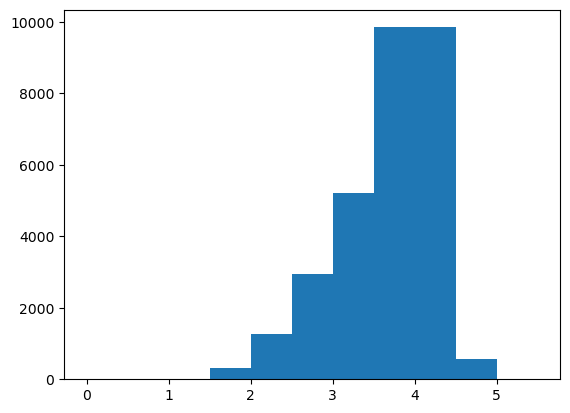

In [69]:
plt.hist(prediction.detach().to('cpu').numpy(),bins=[0,0.5,1,1.5,2,2.5,3,3.5,4.5,5,5.5])

In [ ]:
# Save the model to local disk 
# Set confirm=False if you do not want to be asked for confirmation before saving.
tools.save_model(model, 'recsys.pth', confirm=True)

In [ ]:
# This cell loads the saved model
model = RecommenderSystem(trainset.n_users, trainset.n_items)
tools.load_model(model, 'recsys.pth', device)